In [1]:
# --- CELL 1: SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
%matplotlib inline

# Đường dẫn
DATA_DIR = os.path.join('..', 'data')
MODEL_DIR = os.path.join('..', 'model')
os.makedirs(MODEL_DIR, exist_ok=True)

print("🚛 FLEET AI: Hệ thống thẩm định kỹ thuật phương tiện đã sẵn sàng!")

🚛 FLEET AI: Hệ thống thẩm định kỹ thuật phương tiện đã sẵn sàng!


In [2]:
# --- CELL 2: LOAD & AGGREGATE DATA ---

# 1. Load dữ liệu
trucks = pd.read_csv(os.path.join(DATA_DIR, 'trucks.csv'))
maint = pd.read_csv(os.path.join(DATA_DIR, 'maintenance_records.csv'))
utilization = pd.read_csv(os.path.join(DATA_DIR, 'truck_utilization_metrics.csv'))

print(f"🔹 Trucks List: {trucks.shape}")
print(f"🔹 Maintenance Records: {maint.shape}")
print(f"🔹 Utilization Metrics: {utilization.shape}")

# 2. Xử lý Lịch sử Bảo trì (Maintenance)
# Tính tổng tiền sửa xe và số lần vào xưởng
truck_health = maint.groupby('truck_id').agg({
    'total_cost': 'sum',
    'maintenance_id': 'count',
    'downtime_hours': 'sum' # Tổng thời gian nằm xưởng
}).reset_index()

truck_health.rename(columns={
    'total_cost': 'lifetime_maint_cost',
    'maintenance_id': 'maint_frequency',
    'downtime_hours': 'total_downtime'
}, inplace=True)

# 3. Xử lý Hiệu suất (Utilization)
# Lấy trung bình số dặm chạy được hàng tháng (Xe chạy nhiều hay ít)
truck_usage = utilization.groupby('truck_id')['total_miles'].mean().reset_index(name='avg_monthly_miles')

print("✅ Đã tổng hợp xong hồ sơ sức khỏe xe!")
truck_health.head()

🔹 Trucks List: (120, 11)
🔹 Maintenance Records: (2920, 12)
🔹 Utilization Metrics: (3312, 10)
✅ Đã tổng hợp xong hồ sơ sức khỏe xe!


,truck_id,lifetime_maint_cost,maint_frequency,total_downtime
0,TRK00001,51775.99,24,713.2
1,TRK00002,54869.04,27,665.3
2,TRK00003,90161.42,41,1133.1
3,TRK00004,38561.82,22,483.2
4,TRK00005,66088.45,33,750.6


In [3]:
# --- CELL 3: MERGE & CLEANING ---
master = trucks.copy()
master = master.merge(truck_health, on='truck_id', how='left')
master = master.merge(truck_usage, on='truck_id', how='left')

# Xử lý năm sản xuất (Quan trọng)
current_year = datetime.now().year
# Ép kiểu số, nếu lỗi hoặc bằng 0 thì coi như xe mới (current_year)
master['model_year'] = pd.to_numeric(master['model_year'], errors='coerce').fillna(current_year)
# Tính tuổi, nếu âm (do dữ liệu sai) thì cho bằng 0
master['truck_age'] = (current_year - master['model_year']).clip(lower=0)

fill_values = {'lifetime_maint_cost': 0, 'maint_frequency': 0, 'total_downtime': 0, 'avg_monthly_miles': 0}
master = master.fillna(value=fill_values)

print(f"🎉 Hồ sơ xe hoàn chỉnh: {master.shape}")

🎉 Hồ sơ xe hoàn chỉnh: (120, 16)


In [4]:
# --- CELL 4: LABELING (LOGIC CÂN BẰNG) ---

# Logic đánh giá:
# 1 (Xe Nát): Tuổi > 10 năm HOẶC Sửa quá 10.000$ HOẶC Nằm xưởng quá 50 giờ
# 0 (Xe Ngon): Còn lại

cond_bad = (
    (master['truck_age'] > 10) |
    (master['lifetime_maint_cost'] > 10000) |
    (master['total_downtime'] > 50)
)

master['fleet_rating'] = np.where(cond_bad, 1, 0)

print("📊 Phân bố chất lượng xe (0: Tốt, 1: Kém):")
print(master['fleet_rating'].value_counts())

📊 Phân bố chất lượng xe (0: Tốt, 1: Kém):
fleet_rating
1    120
Name: count, dtype: int64


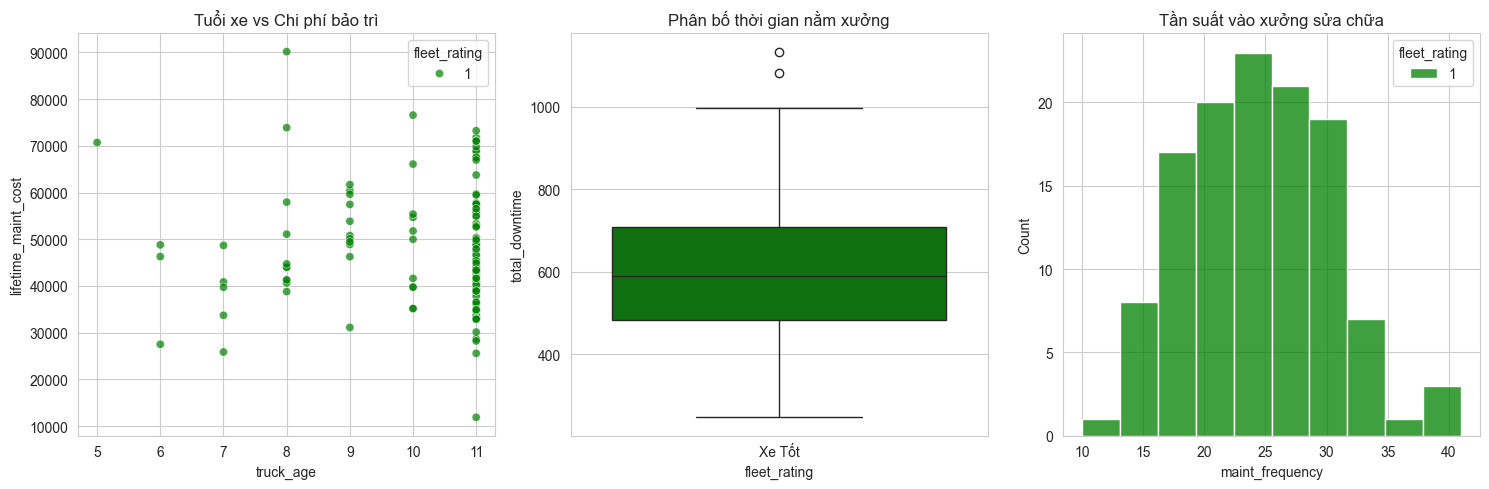

In [5]:
# --- CELL 5: VISUALIZATION (ĐÃ FIX LỖI WARNING) ---

plt.figure(figsize=(15, 5))

# Kiểm tra xem có đủ 2 nhãn không để chọn màu
unique_labels = master['fleet_rating'].unique()
my_palette = ['green', 'red'] if len(unique_labels) > 1 else ['green']

# Biểu đồ 1: Tuổi xe vs Tổng chi phí bảo trì
plt.subplot(1, 3, 1)
sns.scatterplot(data=master, x='truck_age', y='lifetime_maint_cost', hue='fleet_rating', palette=my_palette, alpha=0.7)
plt.title('Tuổi xe vs Chi phí bảo trì')

# Biểu đồ 2: Thời gian chết (Downtime) vs Đánh giá
plt.subplot(1, 3, 2)
# Fix lỗi: Thêm hue và legend=False
sns.boxplot(data=master, x='fleet_rating', y='total_downtime', hue='fleet_rating', legend=False, palette=my_palette)
plt.title('Phân bố thời gian nằm xưởng')
plt.xticks([0, 1] if len(unique_labels) > 1 else [0], ['Xe Tốt', 'Xe Kém'] if len(unique_labels) > 1 else ['Xe Tốt'])

# Biểu đồ 3: Tần suất bảo trì
plt.subplot(1, 3, 3)
sns.histplot(data=master, x='maint_frequency', hue='fleet_rating', multiple="stack", palette=my_palette)
plt.title('Tần suất vào xưởng sửa chữa')

plt.tight_layout()
plt.show()

In [6]:
# --- CELL 6: PREPARE FOR TRAINING ---

# Chọn các cột Feature (Đầu vào)
features = ['truck_age', 'lifetime_maint_cost', 'maint_frequency', 'total_downtime', 'avg_monthly_miles']
X = master[features]
y = master['fleet_rating']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"📚 Dữ liệu học: {X_train.shape}")
print(f"📝 Dữ liệu thi: {X_test.shape}")

📚 Dữ liệu học: (96, 5)
📝 Dữ liệu thi: (24, 5)


In [7]:
# --- CELL 7: TRAINING WITH TUNING ---

print("🧠 Đang tối ưu hóa mô hình Fleet AI...")

# Tham số cần dò tìm
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'] # Quan trọng: Giúp AI chú ý kỹ hơn đến xe hỏng (dữ liệu ít hơn)
}

rf = RandomForestClassifier(random_state=42)

# Chạy Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_fleet_model = grid_search.best_estimator_

print(f"🏆 Tham số tốt nhất: {grid_search.best_params_}")
print("✅ Training hoàn tất!")

🧠 Đang tối ưu hóa mô hình Fleet AI...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
🏆 Tham số tốt nhất: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
✅ Training hoàn tất!


In [8]:
# --- CELL 8: EVALUATION & EXPORT ---

y_pred = best_fleet_model.predict(X_test)

# 1. Độ chính xác
acc = accuracy_score(y_test, y_pred)
print(f"🎯 ĐỘ CHÍNH XÁC (ACCURACY): {acc*100:.2f}%")

# 2. Báo cáo chi tiết
print("\n📜 Classification Report:")
print(classification_report(y_test, y_pred))

# 3. Feature Importance
importances = pd.Series(best_fleet_model.feature_importances_, index=features).sort_values(ascending=False)
print("\n⭐ Yếu tố quyết định chất lượng xe:")
print(importances)

# 4. Lưu Model
save_path = os.path.join(MODEL_DIR, 'fleet_ai.pkl')
joblib.dump(best_fleet_model, save_path)
print(f"💾 Đã lưu model Fleet AI vào: {os.path.abspath(save_path)}")

🎯 ĐỘ CHÍNH XÁC (ACCURACY): 100.00%

📜 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        24

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


⭐ Yếu tố quyết định chất lượng xe:
truck_age              0.0
lifetime_maint_cost    0.0
maint_frequency        0.0
total_downtime         0.0
avg_monthly_miles      0.0
dtype: float64
💾 Đã lưu model Fleet AI vào: D:\logistics_AI\model\fleet_ai.pkl
